# Clustering the Dating Profiles Using Hierarchial Agglomerative Clustering


### Importing the necessary libraries

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

In [4]:
# Loading in the cleaned DF
with open("profiles.pkl",'rb') as pp:
    df = pickle.load(pp)

# Viewing the DF    
df

,Bios,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel
0,Passionate analyst. Incurable pop culture practitioner. Creator. Total troublemaker. Subtly charming food lover. Bacon nerd. Writer.,7,10,5,9,7,6,11,10,8
1,Organizer. Hardcore web guru. Certified coffee ninja. Amateur explorer. Tv maven. Wannabe twitter practitioner. Food expert. Gamer.,12,4,2,1,12,1,4,1,6
2,Hipster-friendly social media scholar. Professional student. Tv junkie. Pop culture practitioner. Reader. Beer fanatic.,8,10,6,3,1,4,2,8,2
3,Writer. Introvert. Beer aficionado. Music specialist. Hipster-friendly tv fanatic.,4,1,9,4,10,7,1,4,12
4,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,11,9,1,5,2,11,5,1,7
...,...,...,...,...,...,...,...,...,...,...
14995,Coffee expert. Unapologetic twitter guru. Avid tv scholar. Internet trailblazer. Alcohol advocate.,8,0,4,8,9,12,2,12,4
14996,Freelance bacon enthusiast. Infuriatingly humble beer guru. Web lover. Reader. Amateur tv maven.,3,9,9,6,2,12,12,6,5
14997,Hardcore twitter practitioner. Extreme web expert. Pop culture evangelist.,7,6,6,11,5,2,11,0,11
14998,Hardcore tv guru. Troublemaker. Typical food lover. Beer expert. Entrepreneur. Analyst. Extreme creator.,8,7,7,1,11,8,1,8,3


## Scaling the categories
### Scaling the categories will decrease the time it takes to fit and transform our clustering algorithm to the dataset

In [5]:
# Instantiating the Scaler
scaler = MinMaxScaler()

# Scaling the categories then replacing the old values
df = df[['Bios']].join(pd.DataFrame(scaler.fit_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))
df

,Bios,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel
0,Passionate analyst. Incurable pop culture practitioner. Creator. Total troublemaker. Subtly charming food lover. Bacon nerd. Writer.,0.583333,0.833333,0.416667,0.750000,0.583333,0.500000,0.916667,0.833333,0.666667
1,Organizer. Hardcore web guru. Certified coffee ninja. Amateur explorer. Tv maven. Wannabe twitter practitioner. Food expert. Gamer.,1.000000,0.333333,0.166667,0.083333,1.000000,0.083333,0.333333,0.083333,0.500000
2,Hipster-friendly social media scholar. Professional student. Tv junkie. Pop culture practitioner. Reader. Beer fanatic.,0.666667,0.833333,0.500000,0.250000,0.083333,0.333333,0.166667,0.666667,0.166667
3,Writer. Introvert. Beer aficionado. Music specialist. Hipster-friendly tv fanatic.,0.333333,0.083333,0.750000,0.333333,0.833333,0.583333,0.083333,0.333333,1.000000
4,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,0.916667,0.750000,0.083333,0.416667,0.166667,0.916667,0.416667,0.083333,0.583333
...,...,...,...,...,...,...,...,...,...,...
14995,Coffee expert. Unapologetic twitter guru. Avid tv scholar. Internet trailblazer. Alcohol advocate.,0.666667,0.000000,0.333333,0.666667,0.750000,1.000000,0.166667,1.000000,0.333333
14996,Freelance bacon enthusiast. Infuriatingly humble beer guru. Web lover. Reader. Amateur tv maven.,0.250000,0.750000,0.750000,0.500000,0.166667,1.000000,1.000000,0.500000,0.416667
14997,Hardcore twitter practitioner. Extreme web expert. Pop culture evangelist.,0.583333,0.500000,0.500000,0.916667,0.416667,0.166667,0.916667,0.000000,0.916667
14998,Hardcore tv guru. Troublemaker. Typical food lover. Beer expert. Entrepreneur. Analyst. Extreme creator.,0.666667,0.583333,0.583333,0.083333,0.916667,0.666667,0.083333,0.666667,0.250000


## Vectorizing the bios
#### Vectorizing is done in order to represent the profile data-specifically bios in vector form
#### As fitting and clustering is easier in numerical form vectoring is necessary
#### We have two approaches for vectorization: CountVectorizer() and TfidVectorizer()
#### Here we have implemented CountVectorizer()

In [6]:
# Instantiating the Vectorizer
vectorizer = CountVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bios'])

In [7]:
# Creating a new DF that contains the vectorized words
df_words = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
df_words

,advocate,aficionado,alcohol,alcoholaholic,amateur,analyst,animals,apathy,avid,award,...,unable,unapologetic,wannabe,web,webaholic,winning,with,writer,zombie,zombieaholic
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
14996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Concatenating the words DF with the original DF
new_df = pd.concat([df, df_words], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
new_df.drop('Bios', axis=1, inplace=True)

# Viewing the new DF
new_df

,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel,advocate,...,unable,unapologetic,wannabe,web,webaholic,winning,with,writer,zombie,zombieaholic
0,0.583333,0.833333,0.416667,0.750000,0.583333,0.500000,0.916667,0.833333,0.666667,0,...,0,0,0,0,0,0,0,1,0,0
1,1.000000,0.333333,0.166667,0.083333,1.000000,0.083333,0.333333,0.083333,0.500000,0,...,0,0,1,1,0,0,0,0,0,0
2,0.666667,0.833333,0.500000,0.250000,0.083333,0.333333,0.166667,0.666667,0.166667,0,...,0,0,0,0,0,0,0,0,0,0
3,0.333333,0.083333,0.750000,0.333333,0.833333,0.583333,0.083333,0.333333,1.000000,0,...,0,0,0,0,0,0,0,1,0,0
4,0.916667,0.750000,0.083333,0.416667,0.166667,0.916667,0.416667,0.083333,0.583333,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.666667,0.000000,0.333333,0.666667,0.750000,1.000000,0.166667,1.000000,0.333333,1,...,0,1,0,0,0,0,0,0,0,0
14996,0.250000,0.750000,0.750000,0.500000,0.166667,1.000000,1.000000,0.500000,0.416667,0,...,0,0,0,1,0,0,0,0,0,0
14997,0.583333,0.500000,0.500000,0.916667,0.416667,0.166667,0.916667,0.000000,0.916667,0,...,0,0,0,1,0,0,0,0,0,0
14998,0.666667,0.583333,0.583333,0.083333,0.916667,0.666667,0.083333,0.666667,0.250000,0,...,0,0,0,0,0,0,0,0,0,0


Looking at the new DataFrame, we have more than 100 features.
Thus, we have to implement Principal Component Anaylsis(PCA) to reduce the dimensionality of our dataset.
PCA is done in order to reduce the number of features, so that only the most important features are considered for the clustering.

## PCA on the DF

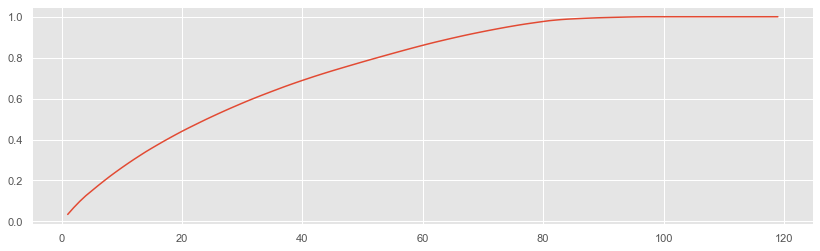

Number features: 85
Total Variance Explained: 0.9911241688861306


In [10]:
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("ggplot")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 99% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_99 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_99 = new_df.shape[1] - n_over_99

print(f"Number features: {n_to_reach_99}\nTotal Variance Explained: {total_explained_variance[n_to_reach_99]}")

###### According to our PCA, the optimal number of features to explain 99.11% of the variance is 85

In [11]:
# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_99)

# Fitting and transforming the dataset to the stated number of features
df_pca = pca.fit_transform(new_df)

# Checking to see if the variance ratio that still remains after the dataset has been reduced
pca.explained_variance_ratio_.cumsum()[-1]

0.989745360691268

##### Thus our new data with 85 features explains 98.97% of the variance of the dataset which is pretty good

# Hierarchical Agglomerative Clustering

### Finding the optimal number of clusters to undergo Clustering

In [20]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(3, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabaz_score(df_pca, cluster_assignments))
    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_

##### Code Breakdown
- Iterating through different quantities of clusters for our clustering algorithm (2-19)
- Fitting the algorithm and assgining the bios to their clusters
- Appending respective evaluations scores (Calinski_Harabaz, Silhoette, Davies_Bouldin) to a list.

### Evaluating the Cluster scores according to their scores

In [21]:
def evaluation(y, x=cluster_cnt):
    
    #Plots the scores of evaluation metric. Prints out the max and min values of the evaluation scores.
    
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nNumer of Clusters', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nNumber of Clusters', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('fivethirtyeight')
    plt.plot(x,y)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.show()

### Calinski-Harabasz Score
- Look for a higher score.

Max Value:
Numer of Clusters    Cluster Score
2     367.274901

Min Value:
Number of Clusters     Cluster Score
18     183.807714


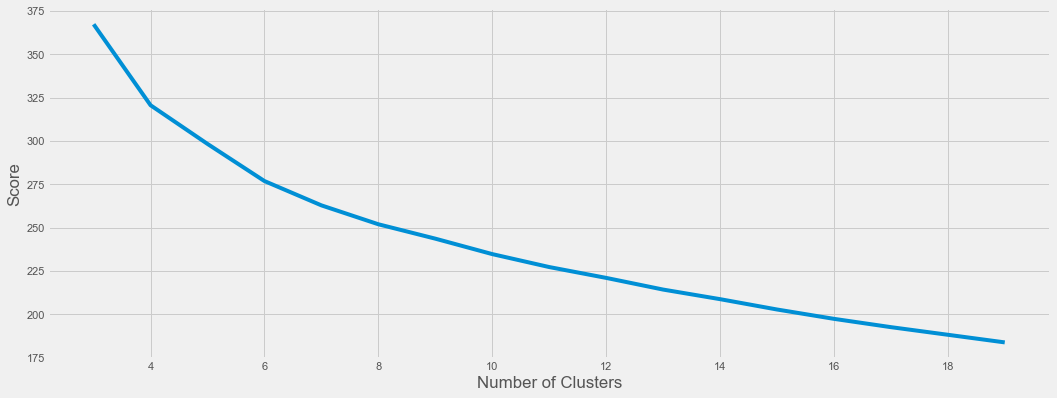

In [22]:
evaluation(ch_scores)

### Silhouette Score
- Aim for higher score.

Max Value:
Numer of Clusters     Cluster Score
17       0.051088

Min Value:
Number of Clusters    Cluster Score
7       0.033243


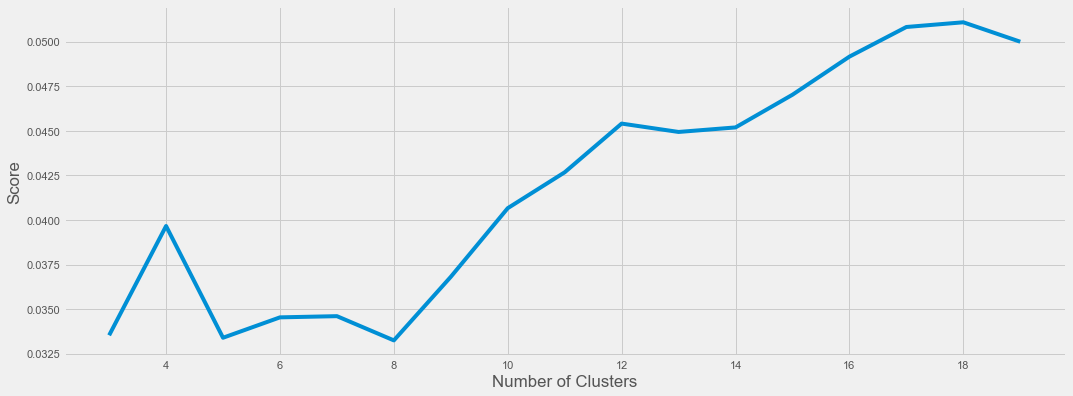

In [23]:
evaluation(s_scores)

### Davies-Bouldin Score
- Look for a lower score.

Max Value:
Numer of Clusters    Cluster Score
5       4.808919

Min Value:
Number of Clusters     Cluster Score
18       3.551638


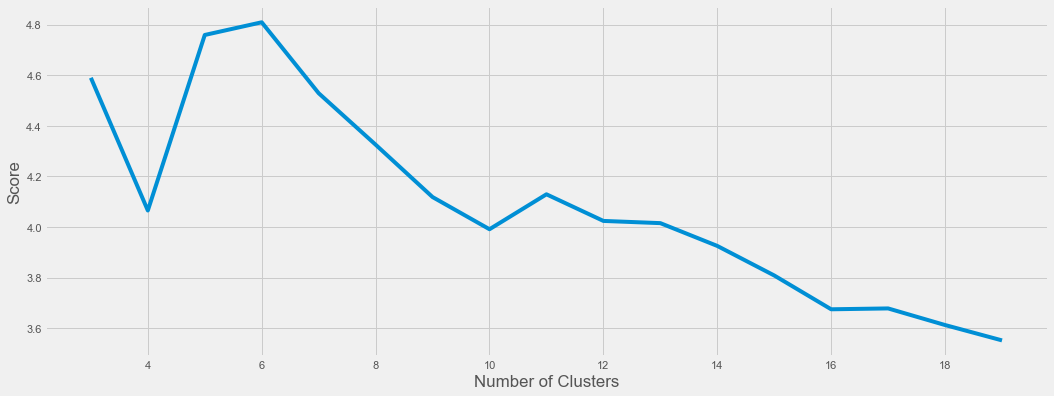

In [24]:
evaluation(db_scores)

Based on the two evaluation metrics, we can use 17 clusters to get the most optimal output

## Running the Clustering Algorithm

In [26]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=17)

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

In [27]:
# Unscaling the categories then replacing the scaled values
df = df[['Bios']].join(pd.DataFrame(scaler.inverse_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))
df

,Bios,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel
0,Passionate analyst. Incurable pop culture practitioner. Creator. Total troublemaker. Subtly charming food lover. Bacon nerd. Writer.,7.0,10.0,5.0,9.0,7.0,6.0,11.0,10.0,8.0
1,Organizer. Hardcore web guru. Certified coffee ninja. Amateur explorer. Tv maven. Wannabe twitter practitioner. Food expert. Gamer.,12.0,4.0,2.0,1.0,12.0,1.0,4.0,1.0,6.0
2,Hipster-friendly social media scholar. Professional student. Tv junkie. Pop culture practitioner. Reader. Beer fanatic.,8.0,10.0,6.0,3.0,1.0,4.0,2.0,8.0,2.0
3,Writer. Introvert. Beer aficionado. Music specialist. Hipster-friendly tv fanatic.,4.0,1.0,9.0,4.0,10.0,7.0,1.0,4.0,12.0
4,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,11.0,9.0,1.0,5.0,2.0,11.0,5.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...
14995,Coffee expert. Unapologetic twitter guru. Avid tv scholar. Internet trailblazer. Alcohol advocate.,8.0,0.0,4.0,8.0,9.0,12.0,2.0,12.0,4.0
14996,Freelance bacon enthusiast. Infuriatingly humble beer guru. Web lover. Reader. Amateur tv maven.,3.0,9.0,9.0,6.0,2.0,12.0,12.0,6.0,5.0
14997,Hardcore twitter practitioner. Extreme web expert. Pop culture evangelist.,7.0,6.0,6.0,11.0,5.0,2.0,11.0,0.0,11.0
14998,Hardcore tv guru. Troublemaker. Typical food lover. Beer expert. Entrepreneur. Analyst. Extreme creator.,8.0,7.0,7.0,1.0,11.0,8.0,1.0,8.0,3.0


In [28]:
# Assigning the clusters to each profile
df['Cluster Number'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Bios,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel,Cluster Number
0,Passionate analyst. Incurable pop culture practitioner. Creator. Total troublemaker. Subtly charming food lover. Bacon nerd. Writer.,7.0,10.0,5.0,9.0,7.0,6.0,11.0,10.0,8.0,1
1,Organizer. Hardcore web guru. Certified coffee ninja. Amateur explorer. Tv maven. Wannabe twitter practitioner. Food expert. Gamer.,12.0,4.0,2.0,1.0,12.0,1.0,4.0,1.0,6.0,12
2,Hipster-friendly social media scholar. Professional student. Tv junkie. Pop culture practitioner. Reader. Beer fanatic.,8.0,10.0,6.0,3.0,1.0,4.0,2.0,8.0,2.0,7
3,Writer. Introvert. Beer aficionado. Music specialist. Hipster-friendly tv fanatic.,4.0,1.0,9.0,4.0,10.0,7.0,1.0,4.0,12.0,7
4,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,11.0,9.0,1.0,5.0,2.0,11.0,5.0,1.0,7.0,9
...,...,...,...,...,...,...,...,...,...,...,...
14995,Coffee expert. Unapologetic twitter guru. Avid tv scholar. Internet trailblazer. Alcohol advocate.,8.0,0.0,4.0,8.0,9.0,12.0,2.0,12.0,4.0,0
14996,Freelance bacon enthusiast. Infuriatingly humble beer guru. Web lover. Reader. Amateur tv maven.,3.0,9.0,9.0,6.0,2.0,12.0,12.0,6.0,5.0,5
14997,Hardcore twitter practitioner. Extreme web expert. Pop culture evangelist.,7.0,6.0,6.0,11.0,5.0,2.0,11.0,0.0,11.0,1
14998,Hardcore tv guru. Troublemaker. Typical food lover. Beer expert. Entrepreneur. Analyst. Extreme creator.,8.0,7.0,7.0,1.0,11.0,8.0,1.0,8.0,3.0,7


## Pickling the Clustered profile into a new file

In [29]:
with open("clustered_profiles.pkl", "wb") as pp:
    pickle.dump(df, pp)

## Further sorting and finding users similar to their profiles

In [30]:
import random

# Randomly choosing a cluster
rand_cluster = random.choice(df['Cluster Number'].unique())

print("For Cluster Group Number", rand_cluster)

# Assigning the Cluster Profiles as a new DF
group = df[df['Cluster Number']==rand_cluster].drop('Cluster Number', axis=1)

# Viewing the newly created DF
group

For Cluster Group Number 9


,Bios,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel
4,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,11.0,9.0,1.0,5.0,2.0,11.0,5.0,1.0,7.0
19,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,2.0,11.0,7.0,9.0,8.0,7.0,7.0,10.0,3.0
34,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,10.0,12.0,7.0,6.0,6.0,3.0,7.0,3.0,7.0
49,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,2.0,6.0,0.0,10.0,5.0,2.0,0.0,2.0,9.0
64,Creator. Unable to type with boxing gloves on. General communicator. Troublemaker. Alcohol geek.,3.0,10.0,2.0,5.0,11.0,12.0,12.0,4.0,11.0
...,...,...,...,...,...,...,...,...,...,...
13972,Evil student. Friendly communicator. Unable to type with boxing gloves on. Infuriatingly humble thinker.,0.0,0.0,3.0,11.0,12.0,10.0,8.0,12.0,12.0
13987,Evil student. Friendly communicator. Unable to type with boxing gloves on. Infuriatingly humble thinker.,11.0,6.0,7.0,2.0,8.0,4.0,6.0,2.0,7.0
14002,Evil student. Friendly communicator. Unable to type with boxing gloves on. Infuriatingly humble thinker.,4.0,2.0,9.0,10.0,6.0,2.0,5.0,9.0,6.0
14017,Evil student. Friendly communicator. Unable to type with boxing gloves on. Infuriatingly humble thinker.,4.0,10.0,5.0,6.0,2.0,8.0,7.0,3.0,3.0


## Vectorizing only the bios in the selected Cluster
- Vectorization technique is CountVectorizer()

In [31]:
# Fitting the vectorizer to the Bios
cluster_x = vectorizer.fit_transform(group['Bios'])

# Creating a new DF that contains the vectorized words
cluster_v = pd.DataFrame(cluster_x.toarray(), index=group.index, columns=vectorizer.get_feature_names())
cluster_v

,aficionado,alcohol,amateur,analyst,avid,bacon,beer,boxing,buff,charming,...,twitter,type,typical,unable,unapologetic,wannabe,web,with,writer,zombie
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
19,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
34,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
49,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
64,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
13987,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
14002,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
14017,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0


In [32]:
# Joining the vector DF and the original DF
group = group.join(cluster_v)

# Dropping the Bios because it is no longer needed in place of vectorization
group.drop('Bios', axis=1, inplace=True)

# Viewing the new DF
group

,Drinks,Perfume,Vacation,Personal Style,Music,Hobby,Food,Scent,Feel,aficionado,...,twitter,type,typical,unable,unapologetic,wannabe,web,with,writer,zombie
4,11.0,9.0,1.0,5.0,2.0,11.0,5.0,1.0,7.0,0,...,0,1,0,1,0,0,0,1,0,0
19,2.0,11.0,7.0,9.0,8.0,7.0,7.0,10.0,3.0,0,...,0,1,0,1,0,0,0,1,0,0
34,10.0,12.0,7.0,6.0,6.0,3.0,7.0,3.0,7.0,0,...,0,1,0,1,0,0,0,1,0,0
49,2.0,6.0,0.0,10.0,5.0,2.0,0.0,2.0,9.0,0,...,0,1,0,1,0,0,0,1,0,0
64,3.0,10.0,2.0,5.0,11.0,12.0,12.0,4.0,11.0,0,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0.0,0.0,3.0,11.0,12.0,10.0,8.0,12.0,12.0,0,...,0,1,0,1,0,0,0,1,0,0
13987,11.0,6.0,7.0,2.0,8.0,4.0,6.0,2.0,7.0,0,...,0,1,0,1,0,0,0,1,0,0
14002,4.0,2.0,9.0,10.0,6.0,2.0,5.0,9.0,6.0,0,...,0,1,0,1,0,0,0,1,0,0
14017,4.0,10.0,5.0,6.0,2.0,8.0,7.0,3.0,3.0,0,...,0,1,0,1,0,0,0,1,0,0


## Finding the matches for a random user within a cluster
### It is done by finding the correlation among the users in the same cluster group

In [33]:
# Transposing the DF so that we are correlating with the index(users)
corr_group = group.T.corr()

corr_group

,4,19,34,49,64,79,94,109,124,139,...,13897,13912,13927,13942,13957,13972,13987,14002,14017,14032
4,1.000000,0.669256,0.838360,0.650986,0.804487,0.852960,0.713699,0.562706,0.783201,0.767696,...,0.531987,0.796155,0.725597,0.673548,0.764117,0.539354,0.795169,0.513942,0.847236,0.756566
19,0.669256,1.000000,0.824914,0.687385,0.822632,0.779037,0.815951,0.867504,0.798023,0.816694,...,0.674204,0.847935,0.787193,0.643319,0.668374,0.776231,0.695638,0.835187,0.879020,0.771336
34,0.838360,0.824914,1.000000,0.711167,0.797516,0.876620,0.917830,0.747581,0.700106,0.900109,...,0.471069,0.875896,0.833630,0.756275,0.774317,0.568016,0.915142,0.736489,0.864597,0.685829
49,0.650986,0.687385,0.711167,1.000000,0.697926,0.559225,0.570434,0.381895,0.545380,0.629526,...,0.299353,0.628084,0.631023,0.674174,0.632073,0.712920,0.571711,0.682983,0.616873,0.630380
64,0.804487,0.822632,0.797516,0.697926,1.000000,0.833996,0.638076,0.797082,0.866505,0.771764,...,0.701145,0.808502,0.876845,0.669377,0.734604,0.811003,0.771330,0.641501,0.833904,0.666368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0.539354,0.776231,0.568016,0.712920,0.811003,0.706034,0.510670,0.682106,0.786198,0.660437,...,0.767734,0.734715,0.761997,0.719033,0.719233,1.000000,0.601550,0.835979,0.622013,0.653780
13987,0.795169,0.695638,0.915142,0.571711,0.771330,0.904330,0.809672,0.767591,0.661478,0.927973,...,0.615308,0.919831,0.820889,0.803389,0.768184,0.601550,1.000000,0.720933,0.755639,0.622280
14002,0.513942,0.835187,0.736489,0.682983,0.641501,0.773066,0.787100,0.716628,0.693748,0.763946,...,0.592903,0.794087,0.791121,0.741192,0.772434,0.835979,0.720933,1.000000,0.690465,0.725700
14017,0.847236,0.879020,0.864597,0.616873,0.833904,0.837890,0.820711,0.752958,0.838354,0.751614,...,0.550333,0.808374,0.857272,0.564803,0.754390,0.622013,0.755639,0.690465,1.000000,0.858924


### Finding the top 10 profile matches for a given user from a cluster

In [35]:
random_user = random.choice(corr_group.index)

print("Top 10 most similar users to User Number:", random_user, '\n')

top_10_similar = corr_group[[random_user]].sort_values(by=[random_user],axis=0, ascending=False)[1:11]

print(top_10_similar)

print("\nThe most similar user to User Number:", random_user, "is User Number", top_10_similar.index[0])

Top 10 most similar users to User Number: 8042 

           8042
12329  0.939562
5010   0.933609
8222   0.929827
8075   0.927583
4434   0.921044
8552   0.920649
8338   0.916822
8061   0.913069
4356   0.909379
10391  0.908690

The most similar user to User Number: 8042 is User Number 12329
